# KNN邻近模型

## 模型思想

![jupyter](./class_thirteen_1.png)

模型的本质是寻找k个最近样本，然后基于最近样本做预测。对于离散型的因变量，从k个最近的已知类别样本中挑选出频率最高的类别用于未知样本的判断；对于连续型的因变量，则是将k个最近的已知样本的均值用于样本的预测

## 模型执行步骤  
1.确定未知样本近邻的个数k值  
2.根据某种度量样本间相似度的指标（如欧式距离）将每一个未知类别样本的最近k个已知样本搜寻出来，形成一个个簇  
3.对搜寻出来的已知样本进行投票，将各簇下类别最多的分类作为未知样本点的预测

## k值选择  
1.k值过于偏小，可能会导致模型过拟合；k值偏大，可能会使模型欠拟合  
2.投票权重：已知样本距离未知样本比较远时，对应的权重就设置的低一点；否则权重就高一点；通常可以将权重设置为距离的倒数  
3.多重交叉验证：将k取不同的值，然后再每种值下执行m重交叉验证，最后选出平均误差最小的k值

## 距离度量

### 欧氏距离

![jupyter](./class_thirteen_2.png)

### 曼哈顿距离

![jupyter](./class_thirteen_3.png)

### 余弦相似度

![jupyter](./class_thirteen_4.png)

## K邻近模型

neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', p=2, metric='minkowski')  
n_neighbors：用于指定邻近样本个数K，默认为5  
weights：用于指定邻近样本的投票权重，默认为'uniform'，表示所有邻近样本投票权重一致；'distance',则表示投票权重与距离成反比，即邻近样本与未知类别的样本点距离越远，权重越小  
metric：用于指定距离的度量指标，默认为闵可夫斯基距离  
p：当参数metric为闵可夫斯基距离时：p=1，表示计算点之间的曼哈顿距离；p=2，表示计算点之间的欧式距离；该参数的默认值为2  

## 分类模型

In [4]:
# 数据导入
import pandas as pd
knowledge = pd.read_excel(r'./data_class/Knowledge.xlsx')
knowledge.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,Very Low
1,0.08,0.08,0.10,0.24,0.90,High
2,0.06,0.06,0.05,0.25,0.33,Low
3,0.10,0.10,0.15,0.65,0.30,Middle
4,0.08,0.08,0.08,0.98,0.24,Low


In [8]:
# 构造训练集和测试集
from sklearn import model_selection
predictors = knowledge.columns[:-1]
x_train, x_test, y_train, y_test = model_selection.train_test_split(knowledge[predictors], knowledge.UNS, test_size=0.25, random_state=1234)

In [9]:
import numpy as np
from sklearn import neighbors
import matplotlib.pyplot as plt

In [12]:
#设置待测试的不同k值
K = np.arange(1, np.ceil(np.log2(knowledge.shape[0])).astype(int))
K

array([1, 2, 3, 4, 5, 6, 7, 8])

In [15]:
# 使用10组交叉验证的方法， 比对每一个k值下KNN模型预测的准确率
accuracy = []
for k in K:
    cv_result = model_selection.cross_val_score(neighbors.KNeighborsClassifier(n_neighbors=k, weights='distance'), x_train, y_train, cv=10, scoring='accuracy')
    accuracy.append(cv_result.mean())
accuracy

[0.844301075268817,
 0.844301075268817,
 0.8277419354838711,
 0.8706451612903227,
 0.8940860215053764,
 0.8938709677419355,
 0.8872043010752687,
 0.8872043010752689]

<function matplotlib.pyplot.show(close=None, block=None)>

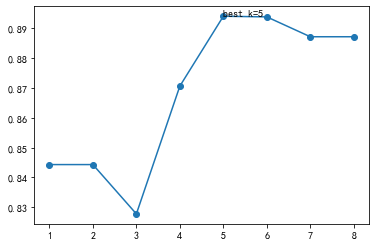

In [18]:
#绘制不同k值与平均预测准确率之间的折线图
## 从k个平均准确率中挑选出最大值所对应的下标
arg_max = np.array(accuracy).argmax()
## 绘图
plt.plot(K, accuracy)
## 添加点图
plt.scatter(K, accuracy)
## 添加文字说明
plt.text(K[arg_max], accuracy[arg_max], 'best k=%s'%int(K[arg_max]))
plt.show

In [19]:
from sklearn import metrics 

In [20]:
# 重新构建模型，并将最佳近邻个数设置为5
knn_class = neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance')
# 模型拟合
knn_class.fit(x_train, y_train)
# 模型在测试集上的预测
predict = knn_class.predict(x_test)
# 构建混淆矩阵
cm = pd.crosstab(predict, y_test)
cm

UNS,High,Low,Middle,Very Low
row_0,,,,
High,29,0,0,0
Low,0,34,3,5
Middle,1,0,23,0
Very Low,0,0,0,6


In [21]:
import seaborn as sns

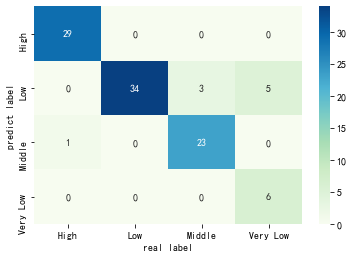

In [22]:
# 将混淆矩阵构造成数据集， 并加上字段名和行名称
cm = pd.DataFrame(cm)
# 绘制热力图
sns.heatmap(cm, annot=True, cmap='GnBu')
# 添加x轴和y轴的标签
plt.xlabel('real label')
plt.ylabel('predict label')
plt.show()

In [26]:
# 模型整体的预测准确率
metrics.accuracy_score(y_test, predict)

0.9108910891089109

In [27]:
# 分类模型的评估报告
print(metrics.classification_report(y_test, predict))

              precision    recall  f1-score   support

        High       1.00      0.97      0.98        30
         Low       0.81      1.00      0.89        34
      Middle       0.96      0.88      0.92        26
    Very Low       1.00      0.55      0.71        11

    accuracy                           0.91       101
   macro avg       0.94      0.85      0.88       101
weighted avg       0.93      0.91      0.91       101



## 回归模型

In [29]:
# 导入数据
ccpp = pd.read_excel(r'./data_class/CCPP.xlsx')
ccpp.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [30]:
from sklearn.preprocessing import minmax_scale

In [33]:
# 数据标准化：对于不同度量单位的数据，需要进行标准化
predictors = ccpp.columns[:-1]
data = minmax_scale(ccpp[predictors])
data

array([[0.37252125, 0.29181495, 0.77159119, 0.63820375],
       [0.66203966, 0.66903915, 0.6718634 , 0.44932976],
       [0.09348442, 0.24982206, 0.47686216, 0.8924933 ],
       ...,
       [0.83597734, 0.87135231, 0.49566939, 0.1463807 ],
       [0.64220963, 0.78451957, 0.51893096, 0.49369973],
       [0.56062323, 0.66120996, 0.60232616, 0.56715818]])

In [34]:
# 数据集拆分
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, ccpp.PE, test_size=0.25, random_state=1234)

In [35]:
# 设置待测试的不同k值
K = np.arange(1, np.ceil(np.log2(ccpp.shape[0])).astype(int))
K

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [37]:
# 使用10组交叉验证的方法， 比较每一个k值下KNN模型的MSE
mse = []
for k in K:
    cv_result = model_selection.cross_val_score(neighbors.KNeighborsRegressor(n_neighbors=k, weights='distance'), x_train, y_train, cv=10, scoring='neg_mean_squared_error')
    mse.append((-1*cv_result).mean())
mse

[20.33826934563699,
 16.217041218126834,
 14.96891605007168,
 14.397793803862973,
 14.097370224457572,
 13.903048322705775,
 13.845159367748613,
 13.889549060735254,
 13.86668415088251,
 13.879219529586749,
 13.901341840751712,
 13.984364297820136,
 14.030171225085516]

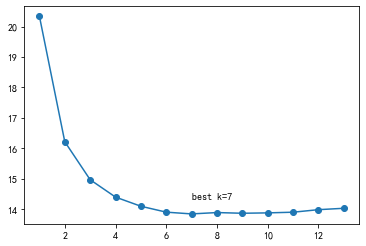

In [38]:
# 从k个平均MSE中挑选出最小值所对应的下标
arg_min = np.array(mse).argmin()
# 绘制折线图
plt.plot(K, mse)
# 添加点
plt.scatter(K, mse)
#添加文字说明
plt.text(K[arg_min], mse[arg_min] + 0.5, 'best k=%s'%int(K[arg_min]))
plt.show()

In [39]:
# 重新构建模型， 并将最佳的近邻个数设置为7
knn_reg = neighbors.KNeighborsRegressor(n_neighbors=7, weights='distance')
knn_reg.fit(x_train, y_train)
predict = knn_reg.predict(x_test)
metrics.mean_squared_error(y_test, predict)

12.814094947334913